In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

In [2]:
# ---- (A) Load MBTA GTFS ----
stops = pd.read_csv("./Data/MBTA_GTFS/stops.txt")
stop_times = pd.read_csv("./Data/MBTA_GTFS/stop_times.txt")
trips = pd.read_csv("./Data/MBTA_GTFS/trips.txt")

# Convert stops to GeoDataFrame
stops_gdf = gpd.GeoDataFrame(
    stops,
    geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
    crs="EPSG:4326"
)


/var/folders/zs/0gklbd017c758v1gqchfcyk00000gn/T/ipykernel_37321/2016082004.py:3: DtypeWarning: Columns (0,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times = pd.read_csv("./Data/MBTA_GTFS/stop_times.txt")


In [3]:

# ---- (B) Load Census Tracts Shapefile ----
tracts = gpd.read_file("./Data/tl_2024_25_tract/tl_2024_25_tract.shp")
# Filter Massachusetts (FIPS = 25)
tracts = tracts[tracts["STATEFP"] == "25"]
boston_tracts = tracts[tracts["COUNTYFP"] == "025"].copy()
boston_tracts = boston_tracts[["GEOID", "geometry"]]



In [4]:
# Ensure CRS match
stops_gdf = stops_gdf.to_crs(boston_tracts.crs)
stops_boston = gpd.sjoin(stops_gdf, boston_tracts, how="inner", predicate="within")

In [5]:
# ---- (C) Load Race Demographics (ACS B03002 Data.csv) ----
race = pd.read_csv("./Data/B03002/Data.csv")

# Clean GEOID (remove "1400000US" prefix)
race["GEOID"] = race["GEO_ID"].str.replace("1400000US", "", regex=False)

# Keep relevant columns
race = race[[
    "GEOID",
    "B03002_001E",  # total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic/Latino
]]





In [6]:
print("Number of rows in race:", len(race))
print("Unique GEOIDs:", race['GEOID'].nunique())
print(race[['GEOID', 'B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_006E', 'B03002_012E']].head(10))  # Check first 10 rows
print(race[['B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_006E', 'B03002_012E']].describe())  # Should show varying mins/maxes/std if correct
print("Unique total populations:", race['B03002_001E'].nunique())  # Should be >1 if tract-level

Number of rows in race: 1621
Unique GEOIDs: 1621
         GEOID       B03002_001E  \
0    Geography  Estimate!!Total:   
1  25001010100              3681   
2  25001010206              4371   
3  25001010208              1675   
4  25001010304              2745   
5  25001010306              3027   
6  25001010400              3335   
7  25001010500              3007   
8  25001010600              3380   
9  25001010700              3263   

                                         B03002_003E  \
0  Estimate!!Total:!!Not Hispanic or Latino:!!Whi...   
1                                               2747   
2                                               3894   
3                                               1674   
4                                               2558   
5                                               2552   
6                                               3230   
7                                               2908   
8                                               31

In [7]:
# ===================================================
# 2. SPATIAL JOIN: Assign each MBTA stop to a census tract
# ===================================================

# Merge race onto tract shapes
boston_tracts = boston_tracts.merge(race, on="GEOID", how="left")
boston_tracts = boston_tracts.to_crs("EPSG:4326")  # ensure same CRS


race_cols = [
    "B03002_001E",  # Total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic
]

for col in race_cols:
    boston_tracts[col] = pd.to_numeric(boston_tracts[col], errors="coerce")


if "index_right" in stops_boston.columns:
    stops_boston = stops_boston.drop(columns="index_right")

if "index_right" in boston_tracts.columns:
    boston_tracts = boston_tracts.drop(columns="index_right")


stops_with_tract = gpd.sjoin(
    stops_boston,
    boston_tracts,
    how="left",
    predicate="within"
)


# Convert B03002 columns to numeric
race_cols = [
    "B03002_001E",  # Total population
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_006E",  # Asian alone
    "B03002_012E",  # Hispanic
]

for col in race_cols:
    stops_with_tract[col] = pd.to_numeric(stops_with_tract[col], errors="coerce")



/var/folders/zs/0gklbd017c758v1gqchfcyk00000gn/T/ipykernel_37321/947785563.py:29: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  stops_with_tract = gpd.sjoin(


In [8]:
# ===================================================
# 3. ASSIGN ROUTE DEMOGRAPHICS (aggregate stops → route)
# ===================================================

# join stop_times → stops_with_tract → trips
df = stop_times.merge(stops_with_tract, on="stop_id")
df = df.merge(trips[["trip_id", "route_id"]], on="trip_id")

# aggregate demographics for each route
route_demo = df.groupby("route_id").agg({
    "B03002_001E": "mean",
    "B03002_003E": "mean",
    "B03002_004E": "mean",
    "B03002_006E": "mean",
    "B03002_012E": "mean",
}).reset_index()

# compute race percentages (optional but recommended)
route_demo["pct_white"] = route_demo["B03002_003E"] / route_demo["B03002_001E"]
route_demo["pct_black"] = route_demo["B03002_004E"] / route_demo["B03002_001E"]
route_demo["pct_asian"] = route_demo["B03002_006E"] / route_demo["B03002_001E"]
route_demo["pct_hispanic"] = route_demo["B03002_012E"] / route_demo["B03002_001E"]

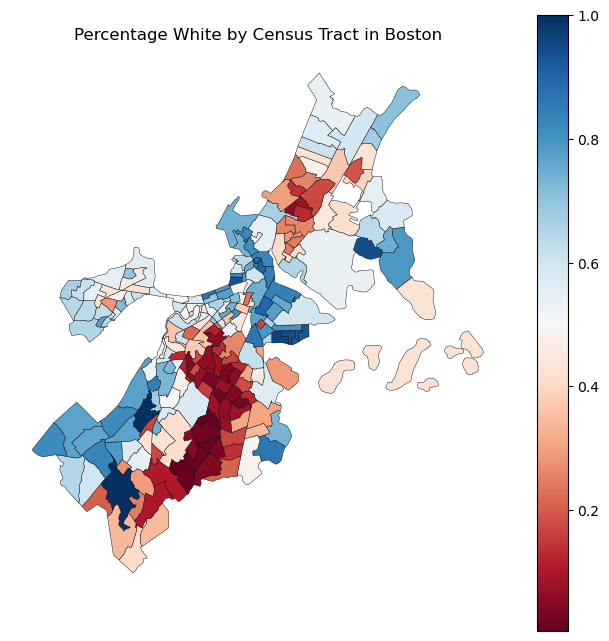

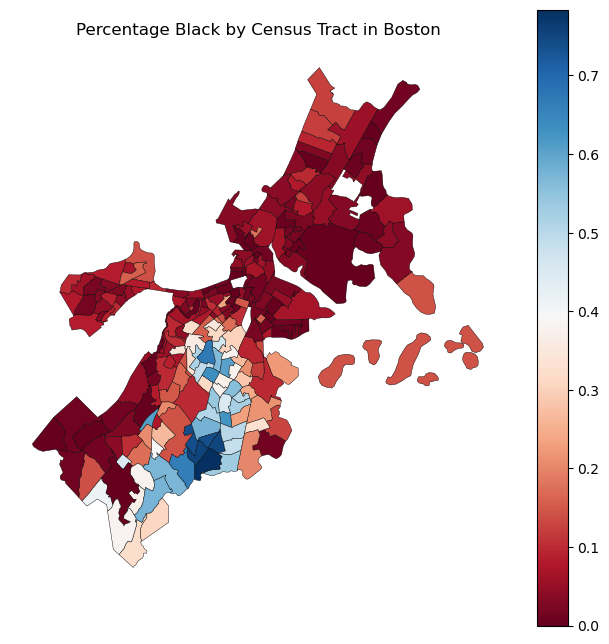

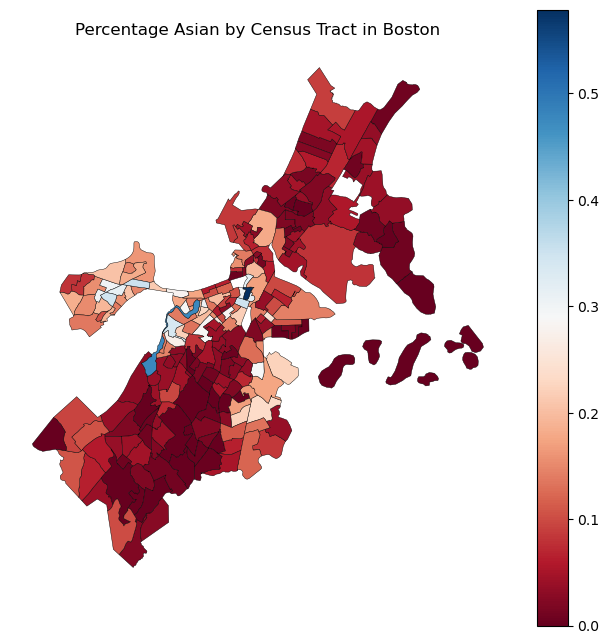

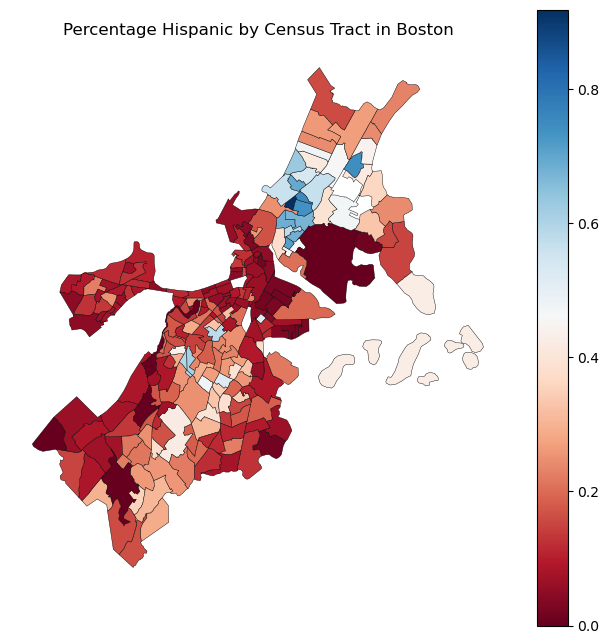

In [9]:
import matplotlib.pyplot as plt

# Define race percentage columns and labels
race_pct_cols = {
    "pct_white": "White",
    "pct_black": "Black",
    "pct_asian": "Asian",
    "pct_hispanic": "Hispanic"
}

# Compute percentages if not already done
boston_tracts["pct_white"] = boston_tracts["B03002_003E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_black"] = boston_tracts["B03002_004E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_asian"] = boston_tracts["B03002_006E"] / boston_tracts["B03002_001E"]
boston_tracts["pct_hispanic"] = boston_tracts["B03002_012E"] / boston_tracts["B03002_001E"]

# Plot each race
for col, label in race_pct_cols.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    boston_tracts.plot(
        column=col,
        cmap="RdBu",      # Red → Blue colormap
        legend=True,
        ax=ax,
        edgecolor='black', # optional: outlines tracts
        linewidth=0.3
    )
    # boston_tracts.plot(ax=ax, cmap="RdBu", edgecolor='blue', linewidth=0.5, legend=True,column=col)
    plt.title(f"Percentage {label} by Census Tract in Boston")
    plt.axis("off")  # optional: remove axis
    plt.show()



Plot MBTA Stops and Tracts Together

Check demographic distribution for the stops

In [10]:
stops_with_tract[["B03002_003E","B03002_004E","B03002_006E","B03002_012E"]].describe()


,B03002_003E,B03002_004E,B03002_006E,B03002_012E
count,3374.000000,3374.000000,3374.000000,3374.000000
mean,1720.417309,676.909306,350.882039,851.256372
std,1120.762455,1034.917690,348.391211,863.272457
min,0.000000,0.000000,0.000000,0.000000
25%,979.500000,75.000000,78.000000,239.000000
50%,1572.000000,215.000000,243.000000,529.000000
75%,2595.000000,734.000000,564.000000,1233.000000
max,5097.000000,4992.000000,2394.000000,5654.000000


Visualize Distribution of Race Percentages Across Stops

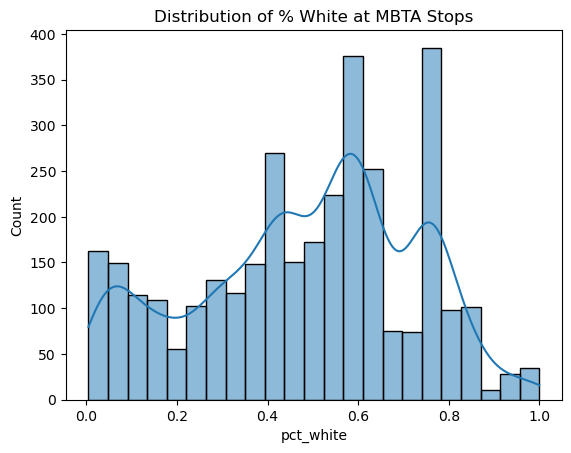

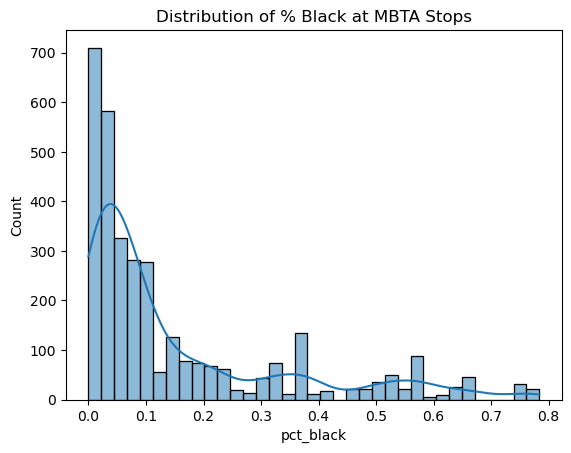

In [11]:
import seaborn as sns

# Ensure B03002 columns are numeric
race_cols = ["B03002_001E","B03002_003E","B03002_004E","B03002_006E","B03002_012E"]

for col in race_cols:
    stops_with_tract[col] = pd.to_numeric(stops_with_tract[col], errors="coerce")

# Compute race percentages
stops_with_tract["pct_white"] = stops_with_tract["B03002_003E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_black"] = stops_with_tract["B03002_004E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_asian"] = stops_with_tract["B03002_006E"] / stops_with_tract["B03002_001E"]
stops_with_tract["pct_hispanic"] = stops_with_tract["B03002_012E"] / stops_with_tract["B03002_001E"]


sns.histplot(stops_with_tract["pct_white"], kde=True)
plt.title("Distribution of % White at MBTA Stops")
plt.show()

sns.histplot(stops_with_tract["pct_black"], kde=True)
plt.title("Distribution of % Black at MBTA Stops")
plt.show()

Bar Chart of Demographics by Route

Scatterplots: Race vs. Headway or Ridership (if available later)

In [12]:
# Load the merged parquet instead of the 2024-only one
arrival = pd.read_parquet("./Data/mbta_arrival_departure_merged_direction.parquet")

# Drop rows with missing stop_id
arrival = arrival.dropna(subset=['stop_id'])

# Convert stop_id from float → int → string, so "75.0" → "75"
arrival['stop_id'] = arrival['stop_id'].astype(int).astype(str)


# Quick look at the data
print(arrival.columns)
print(arrival.head())
print(arrival.dtypes)


Index(['service_date', 'route_id', 'stop_id', 'half_trip_id', 'time_point_id',
       'time_point_order', 'actual', 'scheduled', 'scheduled_headway',
       'headway', 'point_type', 'standard_type', 'earliness', 'direction'],
      dtype='object')
           service_date route_id stop_id  half_trip_id time_point_id  \
0  2018-08-01T00:00:00Z       01      75    40121394.0           mit   
1  2018-08-01T00:00:00Z       01      79    40121394.0         hynes   
2  2018-08-01T00:00:00Z       01     187    40121394.0         masta   
3  2018-08-01T00:00:00Z       01      59    40121394.0         Wasma   
4  2018-08-01T00:00:00Z       01     110    40121565.0         hhgat   

   time_point_order                actual             scheduled  \
0               4.0  1900-01-01T05:19:34Z  1900-01-01T05:19:00Z   
1               5.0  1900-01-01T05:23:20Z  1900-01-01T05:22:00Z   
2               6.0  1900-01-01T05:25:58Z  1900-01-01T05:25:00Z   
3               7.0  1900-01-01T05:28:26Z  1900-01-

In [21]:
print("Number of rows in merged parquet:", len(arrival))

Number of rows in merged parquet: 198706081


In [22]:

arrival['stop_id'] = arrival['stop_id'].astype(float).astype('Int64')

print("Unique stops:", arrival['stop_id'].nunique())
print("Unique routes:", arrival['route_id'].nunique())
print("Unique (route, stop) pairs:", arrival[['route_id','stop_id']].dropna().drop_duplicates().shape[0])


Unique stops: 1425
Unique routes: 187
Unique (route, stop) pairs: 3223


In [14]:
arrival['scheduled'] = pd.to_datetime(
    arrival['scheduled'],
    format='mixed',
    utc=True,
    errors='coerce'
)

arrival['actual'] = pd.to_datetime(
    arrival['actual'],
    format='mixed',
    utc=True,
    errors='coerce'
)

# Convert to datetime if needed
# arrival['scheduled'] = pd.to_datetime(arrival['scheduled'])
# arrival['actual'] = pd.to_datetime(arrival['actual'])

# Compute lateness in minutes
arrival['lateness'] = (arrival['actual'] - arrival['scheduled']).dt.total_seconds() / 60
arrival['scheduled_headway'] = arrival['scheduled_headway'] / 60


# Clip negative lateness to 0 if you only care about being late
arrival['lateness'] = arrival['lateness'].clip(lower=0)

In [15]:
print("scheduled NaN fraction:", arrival['scheduled'].isna().mean())
print("actual NaN fraction:", arrival['actual'].isna().mean())
print("lateness NaN fraction:", arrival['lateness'].isna().mean())


scheduled NaN fraction: 0.0
actual NaN fraction: 0.06663948548207742
lateness NaN fraction: 0.06663948548207742


Average lateness per stop and route

In [16]:
avg_lateness = arrival.groupby(['route_id', 'stop_id']).agg({
    'lateness': 'mean',
    'scheduled_headway': 'mean'  # optional operational feature
}).reset_index()


Merge with stop demographics

In [17]:
avg_lateness['stop_id'] = avg_lateness['stop_id'].astype(str)
stops_with_tract['stop_id'] = stops_with_tract['stop_id'].astype(str)

lateness_demo = avg_lateness.merge(
    stops_with_tract[['stop_id', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']],
    on='stop_id',
    how='left'
)
lateness_demo = lateness_demo.dropna(
    subset=['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic','lateness']
)

lateness_demo.to_csv("./Data/lateness_demo.csv", index=False)

print("Saved: ./Data/lateness_demo.csv")

Saved: ./Data/lateness_demo.csv


In [18]:
# stops_with_tract.value_counts('stop_id')
lateness_demo.head()

,route_id,stop_id,lateness,scheduled_headway,pct_white,pct_black,pct_asian,pct_hispanic
1,01,10590,4.797656,11.323633,0.590849,0.135504,0.099868,0.142543
5,01,187,5.587531,11.446779,0.444758,0.076585,0.198839,0.215003
6,01,188,5.487262,11.318952,0.702962,0.042683,0.155923,0.093206
7,01,2,3.918361,11.326798,0.057253,0.314571,0.038598,0.580251
8,01,59,5.853761,11.444941,0.545237,0.172964,0.145556,0.081426


In [19]:
print("Number of rows in lateness_demo:", len(lateness_demo))


Number of rows in lateness_demo: 1501


In [20]:
cols_needed = [
    "route_id",
    "stop_id",
    "lateness",
    "scheduled_headway",
    "pct_white",
    "pct_black",
    "pct_asian",
    "pct_hispanic"
]

mask_missing = lateness_demo[cols_needed].isna().any(axis=1)
print("Rows with any NaNs in model features:", mask_missing.sum())       # should be 481
print("Rows kept for modeling:", (~mask_missing).sum())                  # should be 1020


Rows with any NaNs in model features: 481
Rows kept for modeling: 1020


In [18]:
# import pandas as pd

# p_old = "./Data/MBTA_Bus_Arrival_Departure_Times_2024.parquet"
# p_new = "./Data/mbta_arrival_departure_merged_direction.parquet"

# arr_old = pd.read_parquet(p_old)
# arr_new = pd.read_parquet(p_new)

# print("=== Columns ===")
# print("OLD:", arr_old.columns.tolist())
# print("NEW:", arr_new.columns.tolist())

# print("\n=== Dtypes ===")
# for col in sorted(set(arr_old.columns).intersection(arr_new.columns)):
#     print(f"{col:20s} | old: {arr_old[col].dtype} | new: {arr_new[col].dtype}")

# # Quick peek
# print("\nOLD head:")
# print(arr_old.head())

# print("\nNEW head:")
# print(arr_new.head())


=== Columns ===
OLD: ['service_date', 'route_id', 'direction_id', 'half_trip_id', 'stop_id', 'time_point_id', 'time_point_order', 'point_type', 'standard_type', 'scheduled', 'actual', 'scheduled_headway', 'headway']
NEW: ['service_date', 'route_id', 'stop_id', 'half_trip_id', 'time_point_id', 'time_point_order', 'actual', 'scheduled', 'scheduled_headway', 'headway', 'point_type', 'standard_type', 'earliness', 'direction']

=== Dtypes ===
actual               | old: category | new: object
half_trip_id         | old: float64 | new: float64
headway              | old: float64 | new: float64
point_type           | old: category | new: object
route_id             | old: category | new: object
scheduled            | old: category | new: object
scheduled_headway    | old: float64 | new: float64
service_date         | old: category | new: object
standard_type        | old: category | new: object
stop_id              | old: int64 | new: float64
time_point_id        | old: category | new: object